<a href="https://colab.research.google.com/github/quynhu-d/hse_risk_management_2/blob/main/notebooks/RM_project2_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Проект 2: Моделирование динамики кривой бескупонной доходности

### Библиотеки

In [99]:
import pandas as pd
import numpy as np

import datetime
from datetime import datetime

from tqdm.auto import tqdm, trange
from copy import copy, deepcopy

import sys
import warnings
warnings.simplefilter("ignore")
from tqdm.auto import tqdm


import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
sns.set_style('whitegrid')

In [100]:
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from statsmodels.api import OLS
from sklearn.model_selection import ParameterGrid, TimeSeriesSplit

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [101]:
# from google.colab import drive
# drive.mount('/content/drive')

# folder = '/content/drive/MyDrive/RM_project/'
folder = './'
file_name = 'КБД.xlsx'

In [102]:
random_seed = 42
np.random.RandomState(seed=random_seed)

RandomState(MT19937) at 0x7F097A2BC140

In [103]:
from stoch_models import *
from data_stats import reduce_with_pca, plot_explained_variance, plot_corr

## Данные

Кривая бескупонной доходности на разные сроки: http://www.cbr.ru/hd_base/zcyc_params/?UniDbQuery.Posted=True&UniDbQuery.From=01.01.2015&UniDbQuery.To=31.12.2022

Данные собраны с января 2003 по май 2023.

In [104]:
# zcc_data = pd.read_excel(folder+file_name)
zcc_data = pd.read_excel('./КБД.xlsx')

In [105]:
'''start_date = '2003-01-01'
end_date = '2023-05-31'

data = pd.DataFrame()
data['Date'] = pd.date_range(start_date, end_date)
data.set_index('Date', inplace=True)

print(data.shape)'''

"start_date = '2003-01-01'\nend_date = '2023-05-31'\n\ndata = pd.DataFrame()\ndata['Date'] = pd.date_range(start_date, end_date)\ndata.set_index('Date', inplace=True)\n\nprint(data.shape)"

In [106]:
#data = data.join(zcc_data.set_index('Date'), on='Date', how='left')
data = zcc_data.set_index('Date')

rename_columns_1 = {'peroid_0.25':'КБД 0.25', 'peroid_0.5':'КБД 0.5', 'peroid_0.75':'КБД 0.75', 'peroid_1':'КБД 1',
                    'peroid_2':'КБД 2', 'peroid_3':'КБД 3', 'peroid_5':'КБД 5', 'peroid_7':'КБД 7',
                    'peroid_10':'КБД 10', 'peroid_15':'КБД 15', 'peroid_20':'КБД 20', 'peroid_30':'КБД 30'}

data.rename(columns=rename_columns_1, inplace=True)

col_list = data.columns

data['year'] = data.index.year

In [107]:
data.reset_index().head(5)

Date  КБД 0.25  КБД 0.5  КБД 0.75  КБД 1  КБД 2  КБД 3  КБД 5  КБД 7  \
0 2003-01-04     11.68    12.31     12.76  13.08  13.63  13.72  13.63  13.53   
1 2003-01-05     11.09    11.70     12.16  12.50  13.14  13.30  13.31  13.27   
2 2003-01-08     10.84    11.61     12.15  12.53  13.18  13.30  13.29  13.24   
3 2003-01-09     10.46    11.13     11.67  12.09  13.02  13.31  13.38  13.32   
4 2003-01-10     10.10    11.08     11.79  12.28  13.14  13.31  13.27  13.19   

   КБД 10  КБД 15  КБД 20  КБД 30  year  
0   13.45   13.38   13.35   13.32  2003  
1   13.23   13.20   13.19   13.17  2003  
2   13.19   13.15   13.13   13.11  2003  
3   13.25   13.19   13.16   13.13  2003  
4   13.11   13.04   13.00   12.97  2003

In [108]:
data.columns

Index(['КБД 0.25', 'КБД 0.5', 'КБД 0.75', 'КБД 1', 'КБД 2', 'КБД 3', 'КБД 5',
       'КБД 7', 'КБД 10', 'КБД 15', 'КБД 20', 'КБД 30', 'year'],
      dtype='object')

## Plotly

In [109]:
!pip install dash
!pip install jupyter-dash

In [110]:
import plotly.express as px

fig = px.line(
    data.reset_index(), x='Date', y=[
            'КБД 0.25', 'КБД 0.5', 'КБД 0.75', 'КБД 1', 'КБД 2', 'КБД 3',
            'КБД 5', 'КБД 7', 'КБД 10', 'КБД 15', 'КБД 20', 'КБД 30'
    ], title='Кривая бескупонной доходности'
)
fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(hovermode="x")
fig.write_html('yc_with_slider.html')
fig.show()

In [90]:
from dash import Dash, dcc, html, Input, Output
import plotly.express as px
from datetime import date
app = Dash(__name__)


app.layout = html.Div([
    html.H4('Кривая бескупонной доходности'),
    dcc.Graph(id="time-series-chart"),
    html.P("Выбрать дату:"),
    dcc.DatePickerSingle(
        id='my-date-picker-single',
        min_date_allowed=date(2003, 1, 4),
        max_date_allowed=date(2023, 5, 31),
        initial_visible_month=date(2023, 5, 31),
        date=date(2023, 5, 31)
    )
])

@app.callback(
    Output("time-series-chart", "figure"),
    # Input("date", "value")
    Input("my-date-picker-single", "date")
)
def display_time_series(date):
    zcc_data = pd.read_excel('./КБД.xlsx')
    data = zcc_data.set_index('Date')

    rename_columns_1 = {
        'peroid_0.25':'КБД 0.25', 'peroid_0.5':'КБД 0.5',
        'peroid_0.75':'КБД 0.75', 'peroid_1':'КБД 1', 'peroid_2':'КБД 2',
        'peroid_3':'КБД 3', 'peroid_5':'КБД 5', 'peroid_7':'КБД 7',
        'peroid_10':'КБД 10', 'peroid_15':'КБД 15', 'peroid_20':'КБД 20',
        'peroid_30':'КБД 30'
    }

    data.rename(columns=rename_columns_1, inplace=True)
    fig = px.line(data.T, x=data.T.index, y=date, title=date)
    return fig

app.run_server(debug=True)

<IPython.core.display.Javascript object>

In [19]:
from dash import Dash, dcc, html, Input, Output
import plotly.express as px
from datetime import date
app = Dash(__name__)


app.layout = html.Div([
    html.H4('Кривая бескупонной доходности (средняя по году)'),
    dcc.Graph(id="time-series-chart"),
    html.P("Выбрать год:"),
    dcc.Dropdown(
        id="year",
        options=np.arange(2003, 2024),
        value=2023,
        clearable=False,
    ),
])

@app.callback(
    Output("time-series-chart", "figure"),
    Input("year", "value")
    # Input("my-date-picker-single", "date")
)
def display_time_series(year):
    zcc_data = pd.read_excel('./КБД.xlsx')
    data = zcc_data.set_index('Date')

    rename_columns_1 = {
        'peroid_0.25':'КБД 0.25', 'peroid_0.5':'КБД 0.5',
        'peroid_0.75':'КБД 0.75', 'peroid_1':'КБД 1', 'peroid_2':'КБД 2',
        'peroid_3':'КБД 3', 'peroid_5':'КБД 5', 'peroid_7':'КБД 7',
        'peroid_10':'КБД 10', 'peroid_15':'КБД 15', 'peroid_20':'КБД 20',
        'peroid_30':'КБД 30'
    }

    data.rename(columns=rename_columns_1, inplace=True)
    col_list = data.columns
    data['year'] = data.index.year
    fig = px.line(
        x=col_list, y=np.mean(data[data.year == year][col_list].T, axis=1),
        title=year
    )
    return fig

app.run_server()

<IPython.core.display.Javascript object>

## Анализ

Графики matplotlib + стандартизация + корреляция кривых

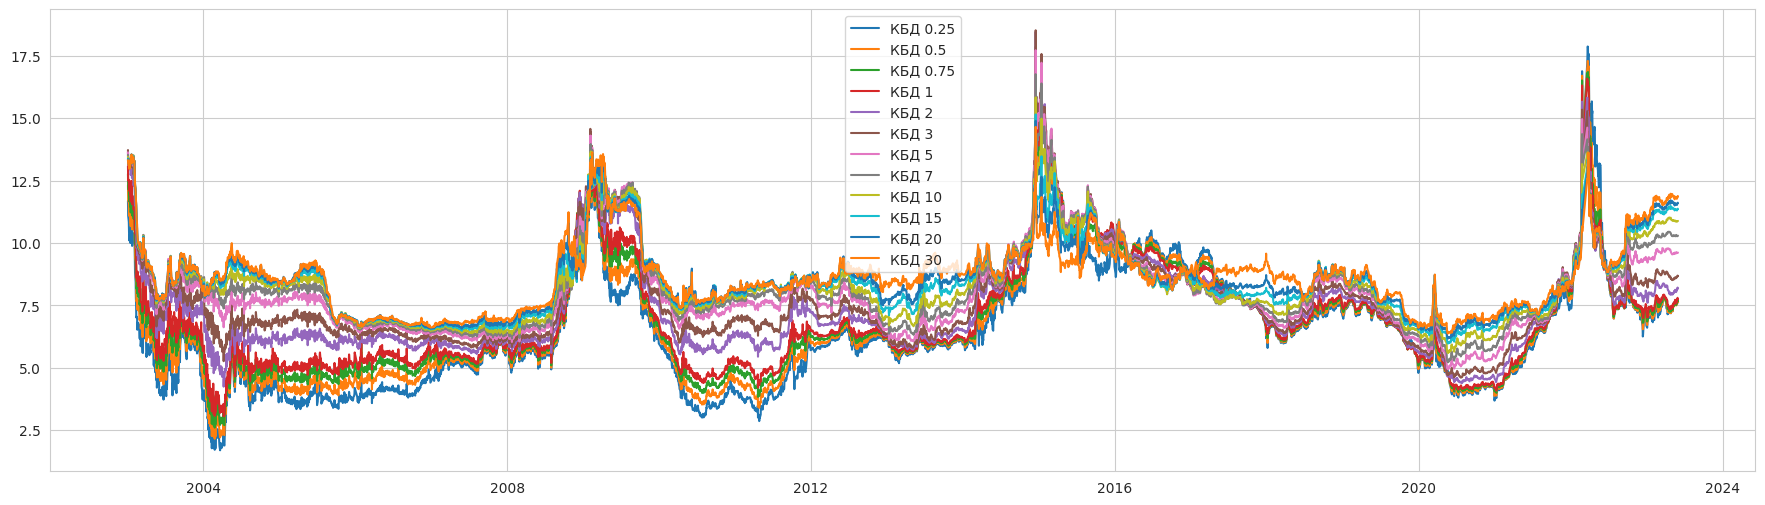

In [ ]:
# Визуализация

fig, axs = plt.subplots(1, 1, figsize=(22, 6))

for i in col_list:
    axs.plot(data[i], label=i)

axs.legend()
plt.show()

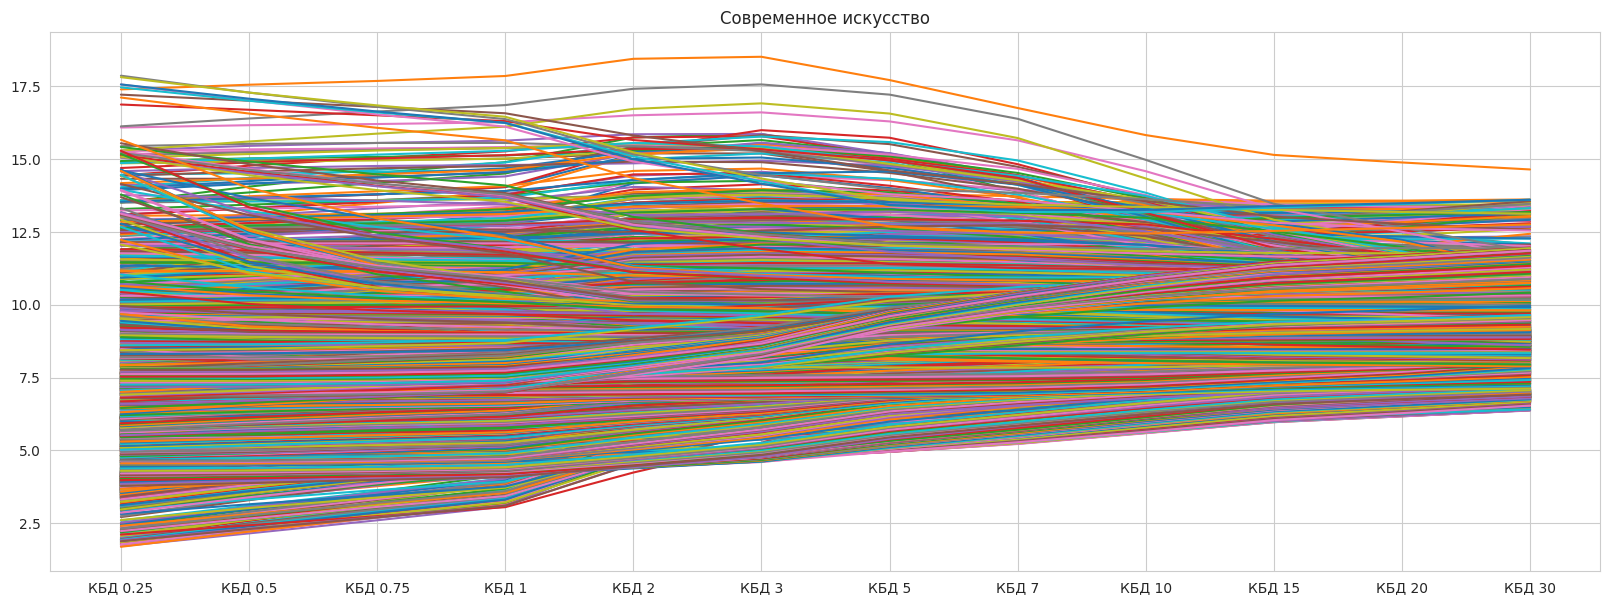

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(20, 7))

for i in data.index:
    axs.plot(col_list, data.loc[i][col_list].values)

axs.set_title('Современное искусство')
plt.show()

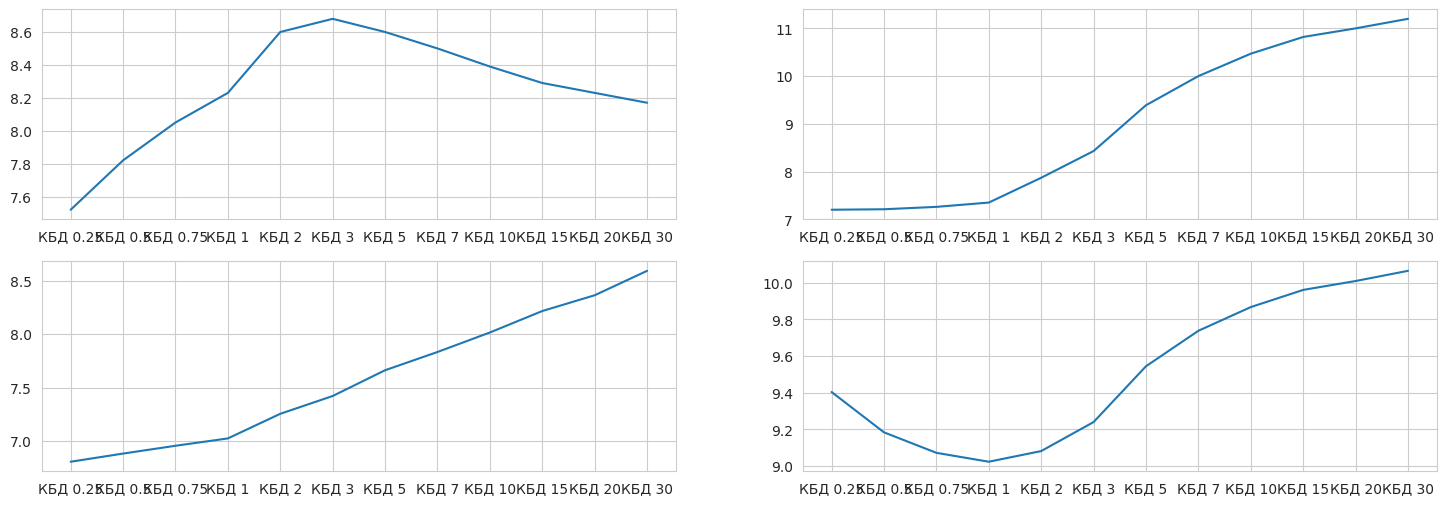

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(22, 6))

axs[0, 0].plot(col_list, data.loc['2021-12-20'].values)
axs[0, 1].plot(col_list, data.loc['2022-12-20'].values)
axs[1, 0].plot(col_list, np.mean(data[data.index.year == 2018][col_list].T, axis=1))
axs[1, 1].plot(col_list, np.mean(data[data.index.year == 2022][col_list].T, axis=1))

plt.show()

In [29]:
# Стандартизация данных
data_st = deepcopy(data)

# Вычитаем среднее и делим на стандартное отклонение
for i in col_list:
    mean_ = np.mean(data_st[i])
    std_ = np.std(data_st[i])
    data_st[i] = (data_st[i] - mean_) / std_

In [111]:
data_st['Среднее'] = data_st[col_list].mean(axis=1)

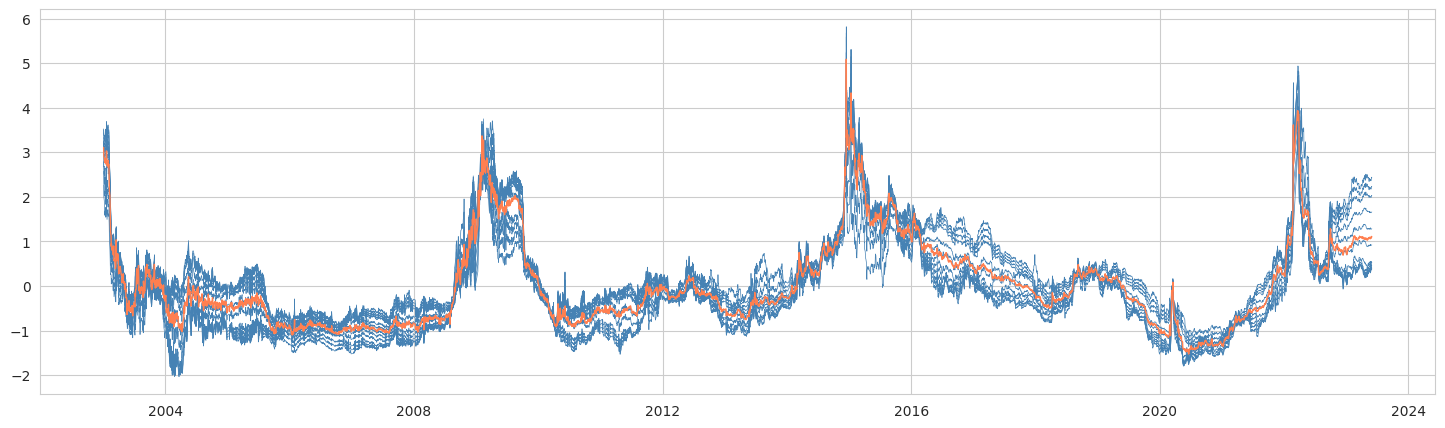

In [112]:
fig, axs = plt.subplots(1, 1, figsize=(18, 5))
for i in col_list:
    axs.plot(data_st[i], linewidth=0.5, color='steelblue')
axs.plot(data_st['Среднее'], linewidth=1, color='coral')
plt.show()

### Корреляция

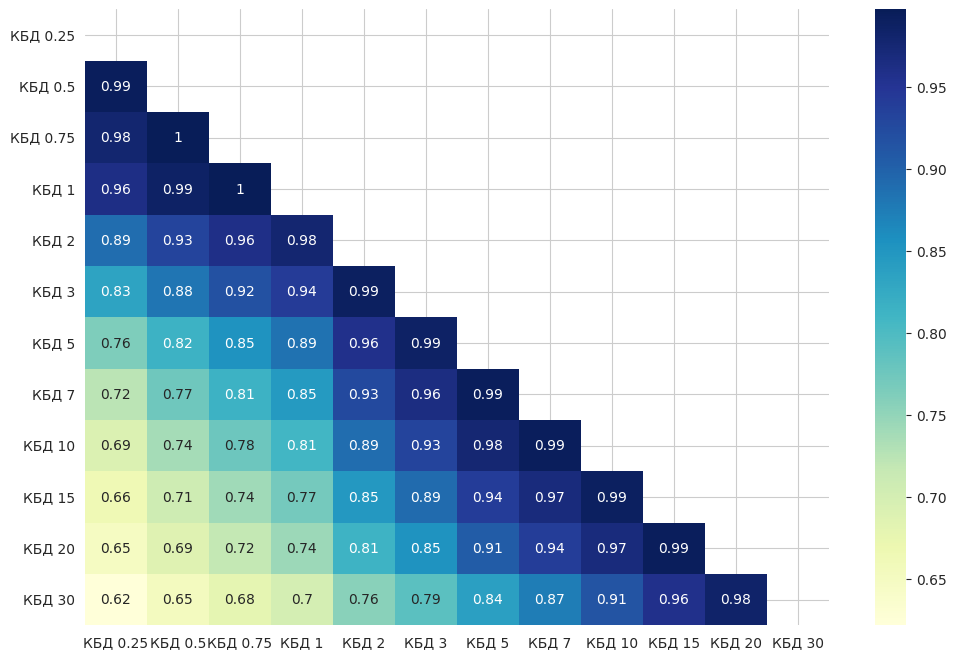

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(12,8))
plot_corr(data_st[col_list], ax=ax)
plt.show()

## PCA

In [32]:
reduced, pca = reduce_with_pca(data_st[col_list], fraction=3)
reduced.shape

(5177, 3)

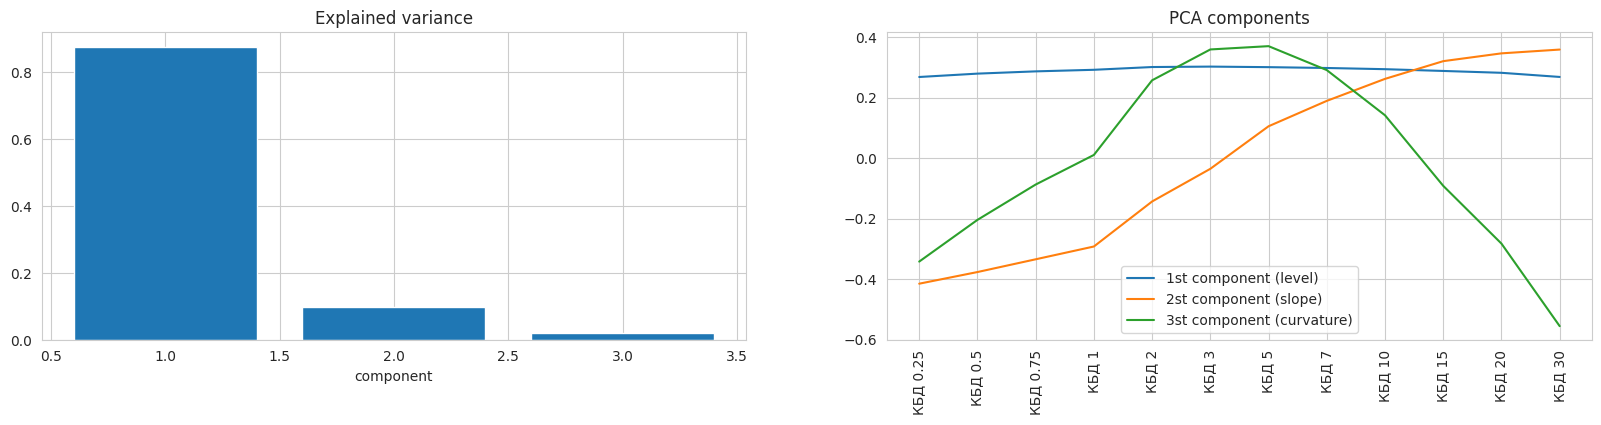

In [98]:
fig, axs = plt.subplots(1,2, figsize=(20,4))
axs[0].bar(x=[1, 2, 3], height=pca.explained_variance_ratio_)
axs[0].set(xlabel='component')
axs[0].set_title('Explained variance')

axs[1].plot(pca.components_.T)
axs[1].legend(['1st component (level)', '2st component (slope)', '3st component (curvature)'])
axs[1].set_xticks(ticks=range(len(col_list)), labels=col_list, rotation='vertical')
axs[1].set_title('PCA components')
plt.show()

In [85]:
pca_df = pd.DataFrame(reduced, index=data_st.index, columns=['pca_1', 'pca_2', 'pca_3'])
pca_df['slope'] = data_st['КБД 30'] - data_st['КБД 0.25']
pca_df['mean yield curve'] = data_st[col_list].mean(axis=1)
pca_df.head(3)

pca_1     pca_2     pca_3     slope  mean yield curve
Date                                                                 
2003-01-04  10.778334  1.134146 -0.171448  1.254931          3.108684
2003-01-05  10.082689  1.355440 -0.179768  1.396415          2.907932
2003-01-08  10.000442  1.355902 -0.101408  1.459043          2.883128

In [89]:
import plotly.express as px

fig = px.line(
    pca_df.reset_index(), x='Date', y=pca_df.columns, title='Yield Curve PCA'
)
fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(hovermode="x")
fig.write_html('pca_with_slider.html')
fig.show()

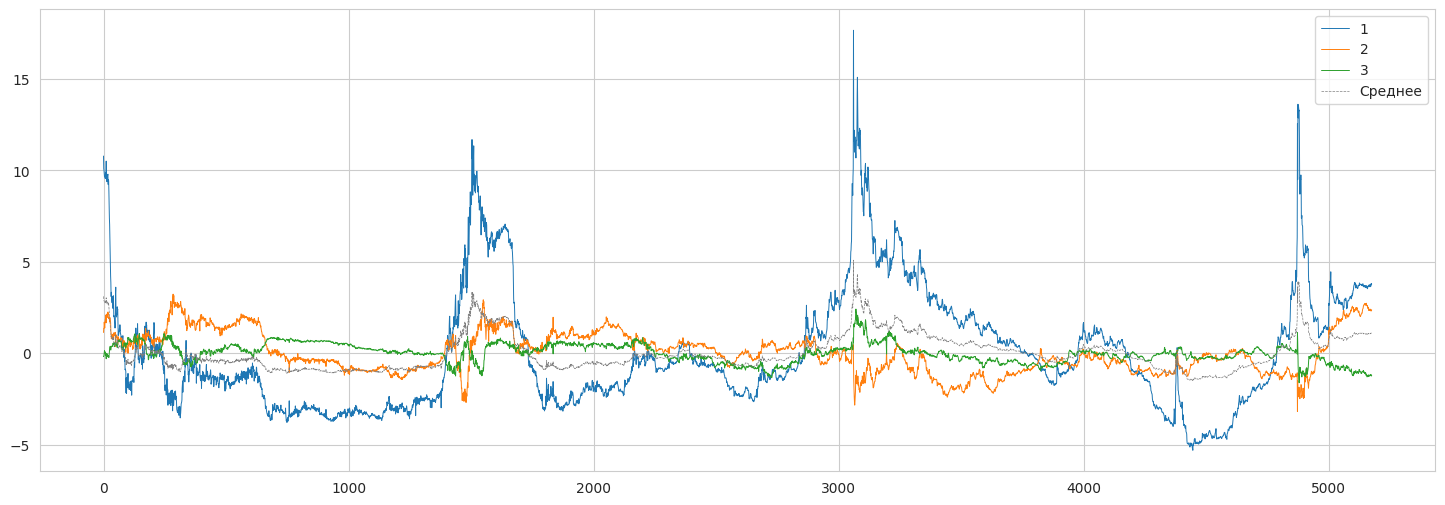

In [84]:
fig, axs = plt.subplots(1, 1, figsize=(18, 6))

for i in range(reduced.shape[1]):
    axs.plot(reduced[:, i], linewidth=0.7, label = i+1)
axs.plot(data_st[col_list].mean(axis=1).values, label = 'Среднее', color='gray', linestyle='--', linewidth=0.5)

axs.legend()
plt.show()

In [118]:
print("Корреляция 1-й компоненты со средней КБД: %.5f" % np.corrcoef(reduced[:,0], (data_st[col_list].mean(axis=1)).values)[0][1])

Корреляция 1-й компоненты со средней КБД: 0.99998


In [119]:
print("Корреляция 2-й компоненты с наклоном: %.5f" % np.corrcoef(reduced[:,1], (data_st['КБД 30'] - data_st['КБД 0.25']).values)[0][1])

Корреляция 2-й компоненты с наклоном: 0.97134


https://fin-plan.org/blog/investitsii/o-chem-govorit-krivaya-dokhodnosti-ofz/